#### importing the required libraries

In [21]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D,GlobalAveragePooling2D, MaxPooling2D, Flatten, Dense, Dropout

### Dataset and path 

In [2]:
# Set the path to the dataset
dataset_path = "Dataset"

# Define the training and testing directories
train_dir = os.path.join(dataset_path, "Training")
test_dir = os.path.join(dataset_path, "Testing")

# Define the categories
categories = ["glioma", "meningioma", "notumor", "pituitary"]

### Loading and Preprocessing data
Here the code will read the iamge from each category in train and will give bar plot according to it 

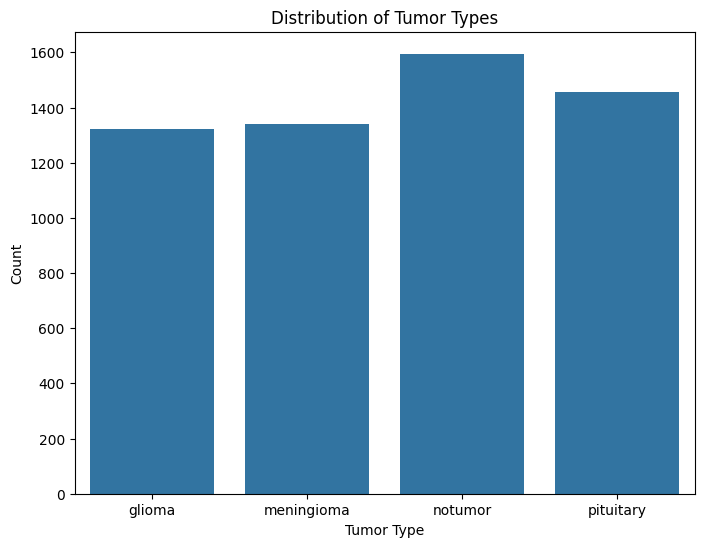

In [3]:
# Load and preprocess the dataset
train_data = []
for category in categories:
    folder_path = os.path.join(train_dir, category)
    images = os.listdir(folder_path)
    count = len(images)
    train_data.append(pd.DataFrame({"Image": images, "Category": [category] * count, "Count": [count] * count}))

train_df = pd.concat(train_data, ignore_index=True)

# Visualize the distribution of tumor types in the training dataset
plt.figure(figsize=(8, 6))
sns.barplot(data=train_df, x="Category", y="Count")
plt.title("Distribution of Tumor Types")
plt.xlabel("Tumor Type")
plt.ylabel("Count")
plt.show()

below code display the sample image of each type of tumor 

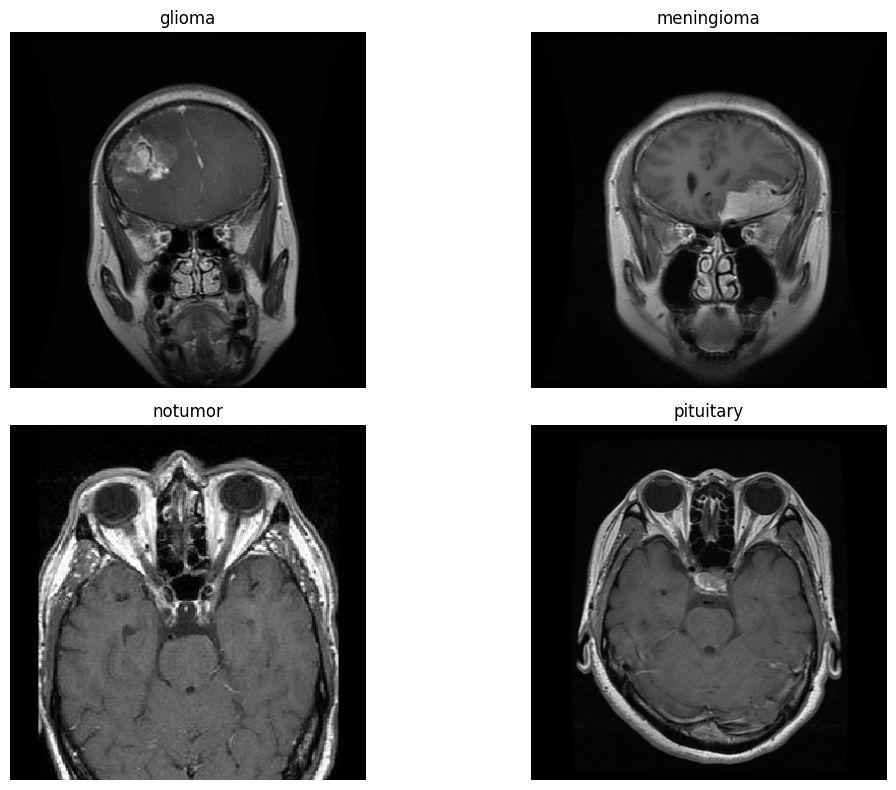

In [4]:
# Visualize sample images for each tumor type
plt.figure(figsize=(12, 8))
for i, category in enumerate(categories):
    folder_path = os.path.join(train_dir, category)
    image_path = os.path.join(folder_path, os.listdir(folder_path)[0])
    img = plt.imread(image_path)
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.title(category)
    plt.axis("off")
plt.tight_layout()
plt.show()

In [5]:
## Set the image size and batch size and epochs for the training the model
image_size = (150, 150)
batch_size = 32
epochs = 50
# These values are chosen based on common practices for training convolutional neural networks (CNNs) on image data.
# - image_size: (150, 150) is a standard size that balances between computational efficiency and retaining enough detail in the images.
# - batch_size: 32 is a commonly used batch size that provides a good balance between training speed and memory usage.
# - epochs: 50 is a reasonable number of epochs to allow the model to learn from the data without overfitting.

### Data Preeprocessing and augmentation 
### Data Preprocessing and Augmentationeprocessing and Augmentation

Data preprocessing transforms raw data into a suitable format for modeling, improving data quality, enhancing model performance, and reducing overfitting. Data augmentation increases dataset diversity by applying transformations like rotation, flipping, scaling, and noise addition, which helps improve model generalization and performance.Data preprocessing transforms raw data into a suitable format for modeling, improving data quality, enhancing model performance, and reducing overfitting. Data augmentation increases dataset diversity by applying transformations like rotation, flipping, scaling, and noise addition, which helps improve model generalization and performance.


In [7]:
# Data augmentation and preprocessing

# ImageDataGenerator:
# - The ImageDataGenerator class in Keras provides a way to generate batches of tensor image data with real-time data augmentation. 
# - It allows for various transformations on the images such as rescaling, rotation, width and height shifts, shear, zoom, and flips.
# - This helps in enhancing the diversity of the training dataset, which can improve the robustness and generalization of the model.
# train_datagen:
# - An instance of ImageDataGenerator configured for training data augmentation.
# - Applies rescaling, rotation, width and height shifts, shear, zoom, horizontal and vertical flips, and nearest fill mode.
# train_generator:
# - Generates batches of augmented image data from the training directory.
# - Uses the configurations specified in train_datagen.
# - Outputs images resized to the target size, in batches of the specified size, and with categorical class mode.
# test_datagen:
# - An instance of ImageDataGenerator configured for testing data preprocessing.
# - Only applies rescaling to the images.
# test_generator:
# - Generates batches of image data from the testing directory.
# - Uses the configurations specified in test_datagen.
# - Outputs images resized to the target size, in batches of the specified size, with categorical class mode, and without shuffling.


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest"
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical"
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


### Building Model Architecture 
+ Conv2D Layer

    + 32 filters, kernel size of (3, 3), ReLU activation, input shape based on image size: This layer applies 32 convolutional filters to the input image, each of size 3x3. The ReLU activation function introduces non-linearity, helping the model learn complex patterns. The input shape specifies the dimensions of the input images.

+ MaxPooling2D Layer

    + Pool size of (2, 2): This layer reduces the spatial dimensions (height and width) of the feature maps by taking the maximum value in each 2x2 window. This helps in reducing the computational load and controlling overfitting.

+ Conv2D Layer

    + 64 filters, kernel size of (3, 3), ReLU activation: Similar to the first Conv2D layer but with 64 filters, allowing the model to learn more complex features.

+ Flatten Layer

    + Converts 2D matrices to a 1D vector: This layer flattens the 2D feature maps into a 1D vector, preparing the data for the fully connected layers.

+ Dense Layer

    + 512 units, ReLU activation: A fully connected layer with 512 neurons and ReLU activation, allowing the model to learn complex combinations of the features extracted by the convolutional layers.

+ Dropout Layer

    + Rate of 0.5: This layer randomly sets 50% of the input units to 0 during training to prevent overfitting by ensuring the model does not rely too heavily on any single neuron.
    
+ Dense Output Layer

    + Number of units equal to the number of categories, softmax activation: The final layer with a number of neurons equal to the number of output classes. The softmax activation function converts the output to a probability distribution over the classes, suitable for multi-class classification.

#### Compilation
+ Optimizer: Adam

    +   The Adam optimizer is an adaptive learning rate optimization algorithm that's efficient and requires little memory. It combines the advantages of two other extensions of stochastic gradient descent, namely AdaGrad and RMSProp.

+ Loss Function: Categorical Crossentropy

    + This loss function is used for multi-class classification problems. It measures the performance of a classification model whose output is a probability value between 0 and 1.

+ Metrics: Accuracy

    + Accuracy is used to evaluate the performance of the model by calculating the ratio of correctly predicted instances to the total instances.

In [8]:
# Define the model architecture

model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(image_size[0], image_size[1], 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation="relu"),
    Dropout(0.5),
    Dense(len(categories), activation="softmax")
])

# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


c:\Users\patel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size
)

Epoch 1/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 45s 253ms/step - accuracy: 0.6754 - loss: 0.7776 - val_accuracy: 0.4969 - val_loss: 1.5048
Epoch 2/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.5625 - loss: 0.9046 - val_accuracy: 0.5484 - val_loss: 1.1568
Epoch 3/50


c:\Users\patel\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


178/178 ━━━━━━━━━━━━━━━━━━━━ 44s 250ms/step - accuracy: 0.7413 - loss: 0.6544 - val_accuracy: 0.5484 - val_loss: 1.0947
Epoch 4/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step - accuracy: 0.7188 - loss: 0.7186 - val_accuracy: 0.9355 - val_loss: 0.4408
Epoch 5/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 44s 249ms/step - accuracy: 0.7673 - loss: 0.5970 - val_accuracy: 0.7523 - val_loss: 0.6074
Epoch 6/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step - accuracy: 0.7812 - loss: 0.5023 - val_accuracy: 0.8710 - val_loss: 0.4131
Epoch 7/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 45s 250ms/step - accuracy: 0.7899 - loss: 0.5374 - val_accuracy: 0.7219 - val_loss: 0.7423
Epoch 8/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - accuracy: 0.7812 - loss: 0.4748 - val_accuracy: 0.9032 - val_loss: 0.4442
Epoch 9/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 45s 250ms/step - accuracy: 0.8278 - loss: 0.4543 - val_accuracy: 0.7422 - val_loss: 0.6606
Epoch 10/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step - accuracy: 0.8125 - loss: 0.6333 - val_ac

### Visulaization 


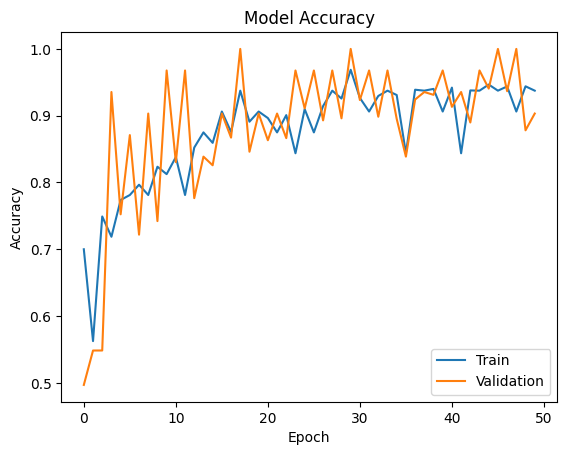

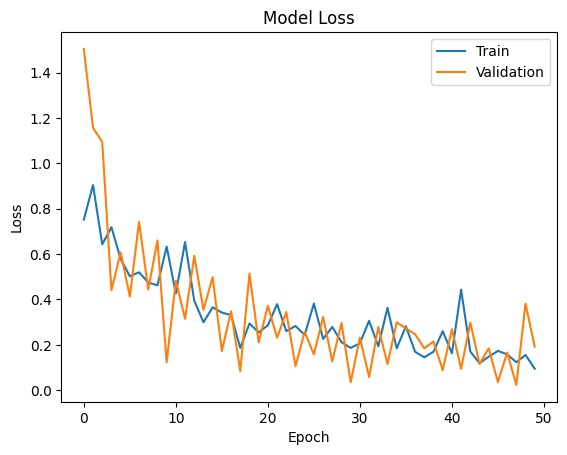

In [12]:
# Plot the training and validation accuracy over epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

# Plot the training and validation loss over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

In [14]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.7989 - loss: 0.6271
Test Loss: 0.3966526687145233
Test Accuracy: 0.8765624761581421


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step


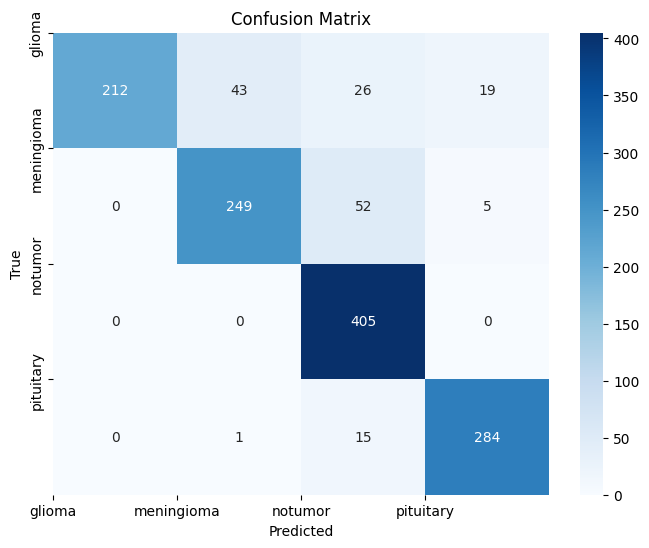

Class: glioma
Precision: 1.0
Recall: 0.7066666666666667
F1-Score: 0.828125

Class: meningioma
Precision: 0.8498293515358362
Recall: 0.8137254901960784
F1-Score: 0.8313856427378965

Class: notumor
Precision: 0.8132530120481928
Recall: 1.0
F1-Score: 0.8970099667774087

Class: pituitary
Precision: 0.922077922077922
Recall: 0.9466666666666667
F1-Score: 0.9342105263157895



In [18]:
# Make predictions on the test dataset
predictions = model.predict(test_generator)
predicted_categories = np.argmax(predictions, axis=1)
true_categories = test_generator.classes

# Create a confusion matrix
confusion_matrix = tf.math.confusion_matrix(true_categories, predicted_categories)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(len(categories)), labels=categories)
plt.yticks(ticks=np.arange(len(categories)), labels=categories)
plt.show()

# Calculate precision, recall, and F1-score from the confusion matrix
precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=0)
recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print precision, recall, and F1-score for each class
for i, category in enumerate(categories):
    print(f"Class: {category}")
    print(f"Precision: {precision[i]}")
    print(f"Recall: {recall[i]}")
    print(f"F1-Score: {f1_score[i]}")
    print()

In [20]:
# Save the model
model.save("brain_tumor.h5")

## Implementing with same thing but this time with ResNET50

In [27]:
# Path to your dataset
train_data_dir = 'Dataset'

# Data augmentation for training images
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2  # Split the data into training and validation sets
)

# Load training and validation data
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)


Found 5619 images belonging to 2 classes.
Found 1404 images belonging to 2 classes.


In [29]:
# transfer learning using the ResNet50 model with a custom top layer for binary classification
# Load the pre-trained ResNet50 model, without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),  # Dropout to prevent overfitting
    Dense(128, activation='swish'),  # Using Swish activation
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification (tumor vs no tumor)
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
            loss='binary_crossentropy',
            metrics=['accuracy'])


In [31]:
# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

# Save the model
model.save('brain_tumor_resnet50.h5')

Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 178s 1s/step - accuracy: 0.7355 - loss: 0.6317 - val_accuracy: 0.8134 - val_loss: 0.4838
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - accuracy: 0.7944 - loss: 0.5304 - val_accuracy: 0.8134 - val_loss: 0.4826
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 176s 999ms/step - accuracy: 0.8188 - loss: 0.5019 - val_accuracy: 0.8134 - val_loss: 0.4838
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 176s 998ms/step - accuracy: 0.8160 - loss: 0.5014 - val_accuracy: 0.8134 - val_loss: 0.4860
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - accuracy: 0.8112 - loss: 0.5060 - val_accuracy: 0.8134 - val_loss: 0.4908
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 176s 998ms/step - accuracy: 0.8076 - loss: 0.5013 - val_accuracy: 0.8134 - val_loss: 0.4841
Epoch 7/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 176s 999ms/step - accuracy: 0.8044 - loss: 0.5061 - val_accuracy: 0.8134 - val_loss: 0.4825
Epoch 8/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 176s 1000ms/step - accuracy: 0.8145 - loss: 0

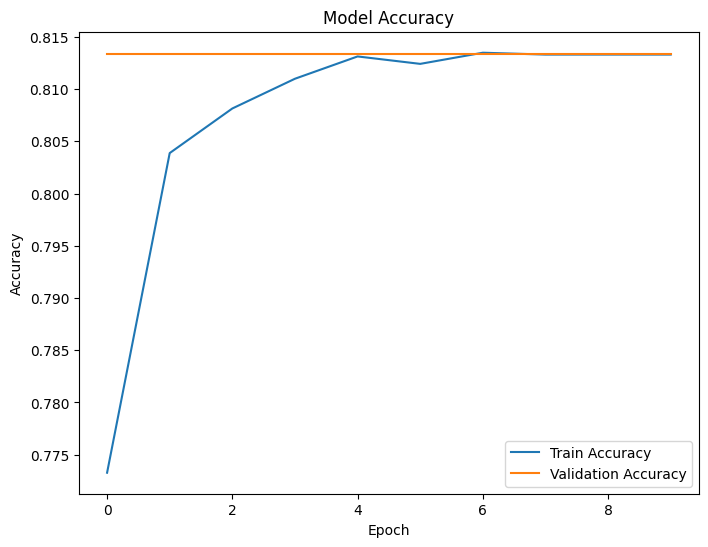

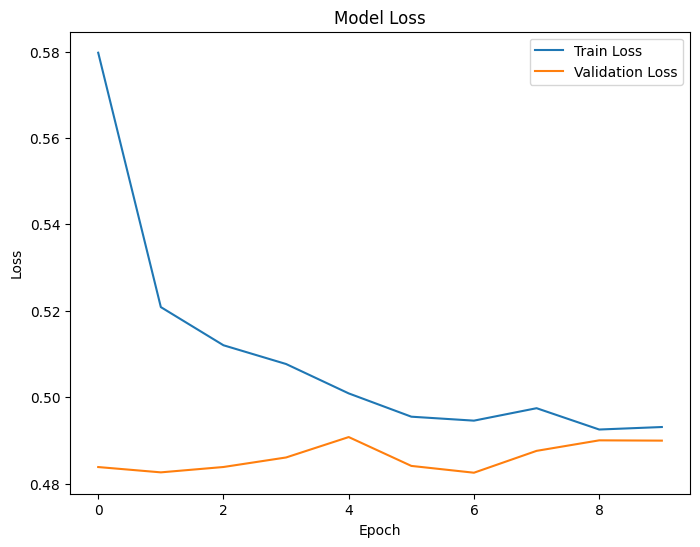

44/44 ━━━━━━━━━━━━━━━━━━━━ 36s 805ms/step


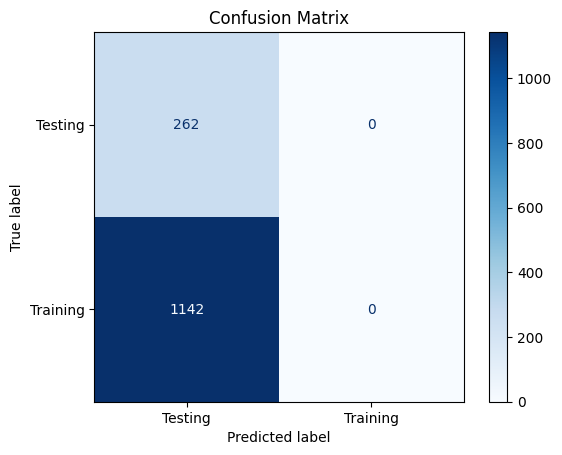

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

def plot_accuracy(history):
    # Plot the training and validation accuracy over epochs
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def plot_loss(history):
    # Plot the training and validation loss over epochs
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_confusion_matrix(model, validation_generator):
    # Make predictions on the validation dataset
    predictions = model.predict(validation_generator)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = validation_generator.classes

    # Create a confusion matrix
    cm = confusion_matrix(true_classes, predicted_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=validation_generator.class_indices.keys())

    # Plot the confusion matrix
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

# Plot accuracy
plot_accuracy(history)

# Plot loss
plot_loss(history)

# Plot confusion matrix
plot_confusion_matrix(model, validation_generator)
